<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
fixed_R = 2
fixed_L = 1
k = 1 # k=1: bif of lambda_1,  k=2: bif of lambda_2


In [2]:
def equations(x):
    A, I, V, l = x

    # k = 1
    r =  fixed_R
    eps = 1e-15 #  a small number
    B      = l-A+r
    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+B**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( B*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*B , eps)/ np.maximum(A, eps) ) 
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    gamma1  = 1/(I - (A-l) * sqA)
    gamma2  = 1/(I - (A-l) * sqB)
    
   
    ABGamma = A * gamma1 + B * gamma2
    ABGammaR= (1/A) * gamma1 + (1/B) * gamma2
    
    # partial_I_partial_A:
    term1_IA = I / (A - l)
    term2_IA = (I**2 - (A - l)**2) / logSBA * ABGammaR
    term3_IA = -(A - l) ** 2 / logSBA * ABGamma
    term4_IA =  (A - l) / logSBA
    
    par_I_par_A = term1_IA + term2_IA + term3_IA + term4_IA
    
    
    # partial_F_partial_I
    par_F_par_I = I * (gamma2 - gamma1) + rho / I
    
    
    #partial_F_partial_A:
    term1_FA = -(I ** 2 * (gamma2 - gamma1) + rho) / (A - l)
    term2_FA = - (A - l)
    term3_FA = (A - l) ** 2 * (A * gamma1 + B * gamma2)
    
    par_F_par_A =  term1_FA + term2_FA + term3_FA

    term1 =  np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  
    equation1 = rho - I * term1
    
    term2 = ((A - l) / logSBA) * (logAB - V + sqA - sqB + (A - l))
    equation2 = I - term2
    
    term3_1 = siglog * ((-1) ** k * I + (A - l))
    term3_2 = (-1) ** k * V - np.log(sigma)
    equation3 = term3_1 - term3_2

    term4_1 = (logSBA / (A - l)) * (par_F_par_A + par_F_par_I * par_I_par_A)
    term4_2 = siglog * ((-1) ** k * par_F_par_I - par_F_par_A)
    equation4 = term4_1 - term4_2

    return [equation1, equation2, equation3, equation4]



In [3]:
num_pts = 10
A_range = np.linspace(0.01, 10, num_pts)
I_range = np.linspace(-60, 60, num_pts)
V_range = np.linspace(-80, 80, num_pts)
l_range = np.linspace(0.01, 10, num_pts)

r = fixed_R
print(r)

Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
mask = ( (I_range > max_expression) | (I_range < min_expression) ) &\
(np.abs(I_range) > eps) & (A_range > eps) & (np.abs(l_range-r) > eps) &\
(l_range > eps) & (l_range - A_range + r > eps)

#A_range = A_range[mask]
#I_range = I_range[mask]
#V_range = V_range[mask]
#l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

# Count the total number of iterations
total_iterations = len(A_range) * len(I_range) * len(l_range)

# Initialize tqdm
pbar = tqdm(total=total_iterations, mininterval=0.1)



import time

# Start the timer
start_time = time.time()

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                #def root_function(var):
                #    return equations([a, i, var, ll])
                # Solve for the variable component only
                #sol = root(root_function, x0[2], method='hybr')
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(sol.x[3]) - np.log(r)) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(sol.x[3]) - np.log(r)  ))

                    mask2 =  ( (sol.x[1] > max_expression2) | (sol.x[1] < min_expression2) ) &\
                    (np.abs(sol.x[1]) > eps) & (sol.x[0] > 0) &  (np.abs(sol.x[3]-r) > eps)   &\
                    (sol.x[3] > 0) & (sol.x[0] < 0.5 * (sol.x[3] +r) )  & (sol.x[3] - sol.x[0] + r > eps)
                    if np.all(mask2): # only append if all elements of mask are True
                        A_sol = np.append(A_sol, sol.x[0])
                        I_sol = np.append(I_sol, sol.x[1])
                        V_sol = np.append(V_sol, sol.x[2])
                        l_sol = np.append(l_sol, sol.x[3])


                      # Update tqdm progress
                    pbar.update(1)
    pbar.update(1)
# Close tqdm
pbar.close()

2


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_33/566279311.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  term1_IA = I / (A - l)
/tmp/ipykernel_33/566279311.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  term2_IA = (I**2 - (A - l)**2) / logSBA * ABGammaR
/tmp/ipykernel_33/566279311.py:26: RuntimeWarning: invalid value encountered in scalar divide
  term3_IA = -(A - l) ** 2 / logSBA * ABGamma
/tmp/ipykernel_33/566279311.py:27: RuntimeWarning: invalid value encountered in scalar divide
  term4_IA =  (A - l) / logSBA
/tmp/ipykernel_33/566279311.py:37: RuntimeWarning: invalid value encountered in scalar divide
  term1_FA = -(I ** 2 * (gamma2 - gamma1) + rho) / (A - l)
/tmp/ipykernel_33/566279311.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term2 = ((A - l) / logSBA) * (logAB - V + sqA - sqB + (A - l))
/tmp/ipykernel_33/566279311.py:53: RuntimeWarning: invalid value encountered in scalar divide
  term4_1 = (logSBA /

In [4]:
L = fixed_L
r = fixed_R
print('The left boundary concentration L is: ', L)
print('The right boundary concentration r is: ', r)
print(r'The solutions are based on the bifurcation of $\lambda_{k}$ where $k$ is:', k)

The left boundary concentration L is:  1
The right boundary concentration r is:  2
The solutions are based on the bifurcation of $\lambda_{k}$ where $k$ is: 1


In [5]:
# Calculate the time passing
end_time = time.time()
time_passing = end_time - start_time
print("Time passing:", time_passing, "seconds")

Time passing: 93.69844961166382 seconds


In [6]:
print(np.shape(V_sol))

(1060,)


In [7]:
# Convert lists to numpy arrays for sorting
A_sol = np.array(A_sol)
I_sol = np.array(I_sol)
V_sol = np.array(V_sol)
l_sol = np.array(l_sol)

Q_sol = fixed_L / l_sol

# Get the sorted indices for V_sol
sorted_indices = np.argsort(V_sol)

# Reorder arrays based on sorted indices
A_sol_ord = A_sol[sorted_indices] 
I_sol_ord = I_sol[sorted_indices]
V_sol_ord = V_sol[sorted_indices]
l_sol_ord = l_sol[sorted_indices] 
Q_sol_ord = Q_sol[sorted_indices]  


In [24]:
A_sol_ord = A_sol_ord[10:]
I_sol_ord = I_sol_ord[10:]
V_sol_ord = V_sol_ord[10:]
l_sol_ord = l_sol_ord[10:]
Q_sol_ord = Q_sol_ord[10:]

print('The length of V is:', len(V_sol_ord))

print('Pick a point from 0 to the length of V:')
bifp = 100
# Based on the figure in the following we detect bifurcation point as follows:
print('')
print('The following points are a set for a bifurcation moment:')
print(f'A, I, V, Q = {A_sol_ord[bifp]:.2f}, {I_sol_ord[bifp]:.2f}, {V_sol_ord[bifp]:.2f}, {Q_sol_ord[bifp]:.2f}')


The length of V is: 990
Pick a point from 0 to the length of V:

The following points are a set for a bifurcation moment:
A, I, V, Q = 1.60, -1.24, -1.85, 0.62


In [25]:
end = 600

print('min(A) =',np.min(A_sol_ord[:-end]))
print('max(A) =',np.max(A_sol_ord[:-end]))

print('min(l) =',np.min(l_sol_ord[:-end]))
print('max(l) =',np.max(l_sol_ord[:-end]))


print('min(V) =',np.min(V_sol_ord[:-end]))
print('max(V) =',np.max(V_sol_ord[:-end]))


print('min(I) =',np.min(I_sol_ord[:-end]))
print('max(I) =',np.max(I_sol_ord[:-end]))

print('min(Q) =',np.min(Q_sol_ord[:-end]))
print('max(Q) =',np.max(Q_sol_ord[:-end]))


min(A) = 0.6507601034175515
max(A) = 1.9840598959133882
min(l) = 0.6507601035338697
max(l) = 1.9840598987601787
min(V) = -14.620606877858304
max(V) = -0.06951330780735239
min(I) = -6.306350505190108
max(I) = -0.051470653975171206
min(Q) = 0.5040170413327194
max(Q) = 1.5366645781903772


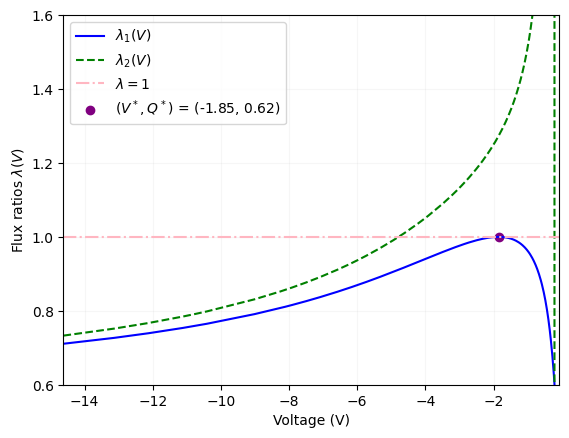

In [26]:
# Bifurcation diagram for variables independent of Q_0:
# Define constants
alpha = 1/3
H1=1

A0 = A_sol_ord[bifp]
I0 = I_sol_ord[bifp]
V0 = V_sol_ord[bifp]
l0 = l_sol_ord[bifp]
Q0 = Q_sol_ord[bifp]
r0 = fixed_R

#V_values = np.linspace(-20, 20, 1000)

j_k = 0.5 * (l0 - A0 + (-1) ** (k + 1) * I_sol_ord)
j_k_0 = alpha * (l0 - r0) * ((-1) ** (k + 1) * V_sol_ord + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))



lmd_k = j_k / j_k_0


j_k2 = 0.5 * (l0 - A0 + (-1) ** (k + 2) * I_sol_ord)
j_k_02 = alpha * (l0 - r0) * ((-1) ** (k + 2) * V_sol_ord + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))

lmd_k2 = j_k2 / j_k_02


# Plot lambda_k(V) versus V for k = 1
plt.plot(V_sol_ord[:-end], lmd_k[:-end], label=r'$\lambda_1(V)$', color='blue', linestyle='-', markersize=1)
plt.plot(V_sol_ord[:-end], lmd_k2[:-end], label=r'$\lambda_2(V)$', color='green', linestyle='--',  markersize=1)

#print(lmd_k[bifp])
# Add horizontal line at lambda_k(V) = 1
plt.axhline(y=1, color='lightpink', linestyle='-.', label=r'$\lambda = 1$')
# Add text on top of the horizontal line
#plt.text(1.1, 0.93, r'$\lambda_1(V) = 1$', fontsize=12, color='green')

# Add text with arrow
#plt.annotate('The max is $\lambda_2(V) =25$', color = 'gray',
#             xy=(-1.4, 1.6),   # Point where the arrow is pointing
#             xytext=(-6.3, 1.4),  # Location of the text
#             arrowprops=dict(facecolor='gray', edgecolor='gray', shrink=0.15, width=1, headwidth=5, headlength=6))

plt.scatter(V0, lmd_k[bifp], color='purple', label=f'$(V^*,Q^*)$ = ({V0:.2f}, {Q0:.2f})')

plt.xlabel('Voltage (V)')
plt.ylabel(r'Flux ratios $\lambda(V)$')
plt.xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))
plt.ylim(0.6, 1.6)

#plt.title('Plot of $\lambda_1(V)$ versus V')
plt.legend()
plt.grid(True, alpha=0.1)  # Set the transparency of the grid
plt.show()



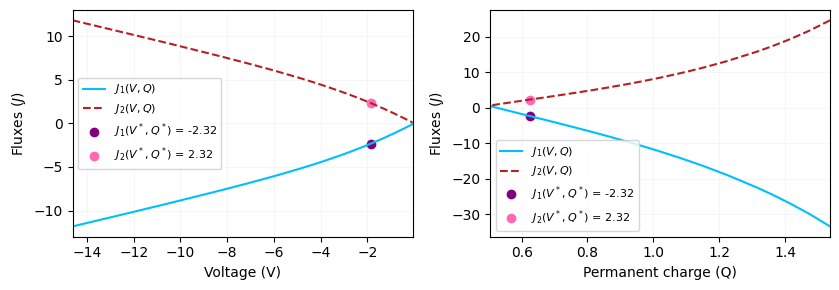

In [27]:
# Flux vs V:
fv1 = 0.5 * (l0 - A0 + (-1) ** (k + 1) * I_sol_ord)
fv2 = 0.5 * (l0 - A0 + (-1) ** (k + 2) * I_sol_ord)

JJ_k = (2 * Q0) * fv1/ (alpha * H1)
JJ_k2 = (2 * Q0) * fv2/ (alpha * H1)

# Flux vs Q:
f1 = 0.5 * (l_sol_ord - A0 + (-1) ** (k + 1) * I_sol_ord)
f2 = 0.5 * (l_sol_ord - A0 + (-1) ** (k + 2) * I_sol_ord)

fQ1 = (2 * Q_sol_ord) * f1/ (alpha * H1)
fQ2 = (2 * Q_sol_ord) * f2/ (alpha * H1)



fig, axs = plt.subplots(1, 2, figsize=(8.5, 3), squeeze=False)

axs[0, 0].plot(V_sol_ord[:-end], JJ_k[:-end], color='deepskyblue', linestyle='-', markersize=1, label='$J_1(V,Q)$')
axs[0, 0].plot(V_sol_ord[:-end], JJ_k2[:-end], color='firebrick', linestyle='--', markersize=1, label='$J_2(V,Q)$')
axs[0, 0].set_xlabel('Voltage (V)')
axs[0, 0].set_ylabel(r'Fluxes $(J)$')
axs[0, 0].set_xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))
axs[0, 0].scatter(V0, JJ_k[bifp], color='purple', label=f'$J_1(V^*,Q^*)$ = {JJ_k[bifp]:0.2f}')
axs[0, 0].scatter(V0, JJ_k2[bifp], color='hotpink', label=f'$J_2(V^*,Q^*)$ = {JJ_k2[bifp]:0.2f}')
axs[0, 0].grid(True, alpha=0.1)
axs[0, 0].legend(prop={'size': 8})


axs[0, 1].plot(Q_sol_ord[:-end], fQ1[:-end], color='deepskyblue', linestyle='-', markersize=1, label='$J_1(V,Q)$')
axs[0, 1].plot(Q_sol_ord[:-end], fQ2[:-end], color='firebrick', linestyle='--', markersize=1, label='$J_2(V,Q)$')
axs[0, 1].set_xlabel('Permanent charge (Q)')
axs[0, 1].set_ylabel(r'Fluxes $(J)$')
axs[0, 1].set_xlim(np.min(Q_sol_ord[:-end]), np.max(Q_sol_ord[:-end]))
axs[0, 1].scatter(Q0, fQ1[bifp], color='purple', label=f'$J_1(V^*,Q^*)$ = {fQ1[bifp]:0.2f}')
axs[0, 1].scatter(Q0, fQ2[bifp], color='hotpink', label=f'$J_2(V^*,Q^*)$ = {fQ2[bifp]:0.2f}')
axs[0, 1].legend(prop={'size': 8})
axs[0, 1].grid(True, alpha=0.1)
#axs[0, 0].set_xlim(-2, -1.5)


plt.tight_layout()
plt.show()


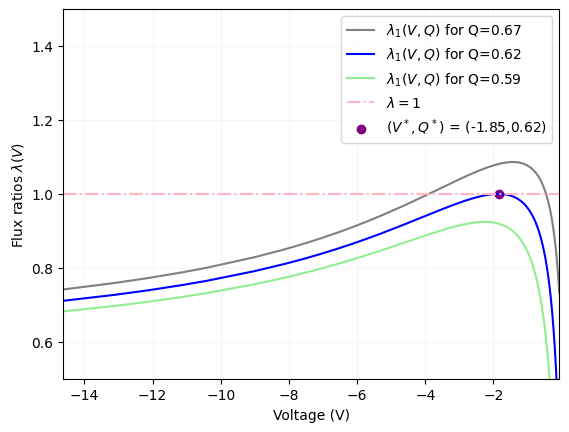

In [28]:
H1 =1
alpha = 1/3
L = fixed_L

L_values = [l0 - 0.1, l0, l0 + 0.1]

plt.figure()

colors = ['gray', 'blue', 'lightgreen']  

jj = [None] * len(L_values)
jj_0 = [None] * len(L_values)
llmd = [None] * len(L_values)

for idx, l in enumerate(L_values):     
    
    jj[idx]   = 0.5 * (l - A0 + (-1) ** (k + 1) * I_sol_ord)
    jj_0[idx] = alpha * (l - r0) * ((-1) ** (k + 1) * V_sol_ord + np.log(l) - np.log(r0)) / (2 * (np.log(l) - np.log(r0)))

    llmd[idx] = jj[idx] / jj_0[idx]

    # Plot lambda_k(V) versus V for k = 1
    plt.plot(V_sol_ord[:-end], llmd[idx][:-end], label=rf'$\lambda_1(V,Q)$ for Q={L/l:.2f}', color=colors[idx], linestyle='-',  markersize=1)


plt.axhline(y=1, color='lightpink', linestyle='-.', label=r'$\lambda = 1$')

plt.scatter(V0, 1, color='purple', label=f'$(V^*,Q^*)$ = ({V0:.2f},{Q0:.2f})')

plt.xlabel('Voltage (V)')
plt.ylabel(r'Flux ratios $\lambda(V)$')
plt.xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))
plt.ylim(0.5, 1.5)
#plt.title('Plot of $\lambda_1(V)$ versus V')
plt.legend()
plt.grid(True, alpha=0.1)  # Set the transparency of the grid
plt.show()


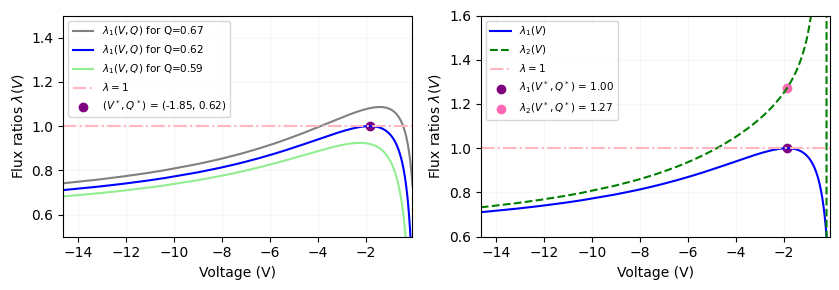

In [29]:
alpha = 1/3



A0 = A_sol_ord[bifp]
I0 = I_sol_ord[bifp]
V0 = V_sol_ord[bifp]
l0 = l_sol_ord[bifp]
Q0 = Q_sol_ord[bifp]
r0 = fixed_R

fig, axs = plt.subplots(1, 2, figsize=(8.5, 3), squeeze=False)

# Panel A: Plotting lambda_1(V) and lambda_2(V)
k = 1  # Assuming k is defined

j_k = 0.5 * (l0 - A0 + (-1) ** (k + 1) * I_sol_ord)
j_k_0 = alpha * (l0 - r0) * ((-1) ** (k + 1) * V_sol_ord + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))
lmd_k = j_k / j_k_0

j_k2 = 0.5 * (l0 - A0 + (-1) ** (k + 2) * I_sol_ord)
j_k_02 = alpha * (l0 - r0) * ((-1) ** (k + 2) * V_sol_ord + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))
lmd_k2 = j_k2 / j_k_02

axs[0, 1].plot(V_sol_ord[:-end], lmd_k[:-end], label=r'$\lambda_1(V)$', color='blue', linestyle='-', markersize=1)
axs[0, 1].plot(V_sol_ord[:-end], lmd_k2[:-end], label=r'$\lambda_2(V)$', color='green', linestyle='--', markersize=1)

axs[0, 1].axhline(y=1, color='lightpink', linestyle='-.', label=r'$\lambda = 1$')

#axs[0, 1].annotate('$\max_{V}~ \lambda_2(V) = 25$', color='gray',
#                   xy=(-1.4, 1.6),  # Point where the arrow is pointing
#                   xytext=(-6.3, 1.4),  # Location of the text
#                   arrowprops=dict(facecolor='gray', edgecolor='gray', shrink=0.15, width=1, headwidth=5, headlength=6))

axs[0, 1].scatter(V0, lmd_k[bifp], color='purple', label=f'$\lambda_1(V^*,Q^*)$ = {lmd_k[bifp]:.2f}')
axs[0, 1].scatter(V0, lmd_k2[bifp], color='hotpink', label=f'$\lambda_2(V^*,Q^*)$ = {lmd_k2[bifp]:.2f}')

axs[0, 1].set_xlabel('Voltage (V)', fontsize=10)
axs[0, 1].set_ylabel(r'Flux ratios $\lambda(V)$', fontsize=10)
axs[0, 1].set_xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))

axs[0, 1].set_ylim(0.6, 1.6)
axs[0, 1].legend(fontsize=7.5)
axs[0, 1].grid(True, alpha=0.1)

# Panel B: Plotting lambda_1(V, Q) for different Q values
L_values = [l0 - 0.1, l0, l0 + 0.1]
colors = ['gray', 'blue', 'lightgreen']

for idx, l in enumerate(L_values):
    jj = 0.5 * (l - A0 + (-1) ** (k + 1) * I_sol_ord)
    jj_0 = alpha * (l - r0) * ((-1) ** (k + 1) * V_sol_ord + np.log(l) - np.log(r0)) / (2 * (np.log(l) - np.log(r0)))
    llmd = jj / jj_0

    axs[0, 0].plot(V_sol_ord[:-end], llmd[:-end], label=rf'$\lambda_1(V,Q)$ for Q={L/l:.2f}', color=colors[idx], linestyle='-', markersize=1)

axs[0, 0].axhline(y=1, color='lightpink', linestyle='-.', label=r'$\lambda = 1$')
axs[0, 0].scatter(V0, 1, color='purple', label=f'$(V^*,Q^*)$ = ({V0:.2f}, {Q0:.2f})')


axs[0, 0].set_xlabel('Voltage (V)', fontsize=10)
axs[0, 0].set_ylabel(r'Flux ratios $\lambda(V)$', fontsize=10)
axs[0, 0].set_xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))
axs[0, 0].set_ylim(0.5, 1.5)
axs[0, 0].legend(prop={'size': 7.5})
axs[0, 0].grid(True, alpha=0.1)

plt.tight_layout()
plt.show()


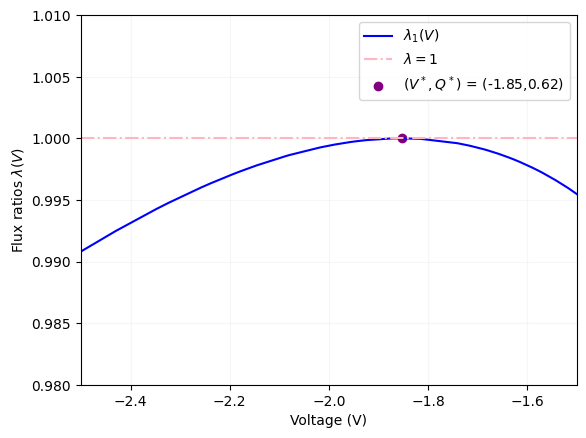

In [30]:
# Bifurcation diagram for variables independent of Q_0:
# Define constants
alpha = 1/3
l0 = l_sol_ord[bifp]
I0 = I_sol_ord[bifp]
A0 = A_sol_ord[bifp]
V0 = V_sol_ord[bifp]
r0 = fixed_R

#V_values = np.linspace(-20, 20, 1000)

j_k = 0.5 * (l0 - A0 + (-1) ** (k + 1) * I_sol_ord)
j_k_0 = alpha * (l0 - r0) * ((-1) ** (k + 1) * V_sol_ord + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))


lmd_k = j_k / j_k_0


# Plot lambda_k(V) versus V for k = 1
plt.plot(V_sol_ord[:-end], lmd_k[:-end], label=r'$\lambda_1(V)$', color='blue', linestyle='-',  markersize=1)

plt.axhline(y=1, color='lightpink', linestyle='-.', label=r'$\lambda = 1$')
# Add text on top of the horizontal line
#plt.text(1.1, 0.93, r'$\lambda_1(V) = 1$', fontsize=12, color='green')


plt.scatter(V0, lmd_k[bifp], color='purple', label=f'$(V^*,Q^*)$ = ({V0:.2f},{Q0:.2f})')

plt.xlabel('Voltage (V)')
plt.ylabel(r'Flux ratios $\lambda(V)$')
plt.xlim(-2.5,-1.5 )
plt.ylim(0.98, 1.01)
#plt.title('Plot of $\lambda_1(V)$ versus V')
plt.legend()
plt.grid(True, alpha=0.1)  # Set the transparency of the grid
plt.show()



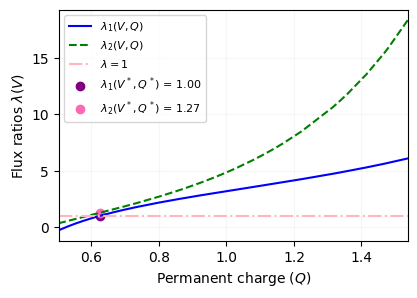

In [35]:
# Define constants
alpha = 1/3

H1 = 1
A0 = A_sol_ord[bifp]
r0 = fixed_R

jj_k = 0.5 * (l_sol_ord - A0 + (-1) ** (k + 1) * I_sol_ord)
jj_k_0 = alpha * (l_sol_ord - r0) * ((-1) ** (k + 1) * V0 + np.log(l_sol_ord) - np.log(r0)) / (2 * (np.log(l_sol_ord) - np.log(r0)))

llmd_k = jj_k / jj_k_0


jj_k2 = 0.5 * (l_sol_ord - A0 + (-1) ** (k + 2) * I_sol_ord)
jj_k_02 = alpha * (l_sol_ord - r0) * ((-1) ** (k + 2) * V0 + np.log(l_sol_ord) - np.log(r0)) / (2 * (np.log(l_sol_ord) - np.log(r0)))

llmd_k2 = jj_k2 / jj_k_02

fig, axs = plt.subplots(1, 1, figsize=(4.5, 3), squeeze=False)

plt.plot(Q_sol_ord[:-end], llmd_k[:-end], label=r'$\lambda_1(V,Q)$', linestyle='-', color='blue',  markersize=1)
plt.plot(Q_sol_ord[:-end], llmd_k2[:-end], label=r'$\lambda_2(V,Q)$', color='green', linestyle='--',  markersize=1)

plt.axhline(y=1, color='lightpink', linestyle='-.', label=r'$\lambda = 1$')
#plt.scatter(Q0, 1, color='purple', label=f'$(V^*,Q^*)$ = ({V0:.2f}, {Q0:.2f})')
plt.scatter(Q0, llmd_k[bifp], color='purple', label=f'$\lambda_1(V^*,Q^*)$ = {lmd_k[bifp]:.2f}')
plt.scatter(Q0, llmd_k2[bifp], color='hotpink', label=f'$\lambda_2(V^*,Q^*)$ = {lmd_k2[bifp]:.2f}')

# Add text on top of the horizontal line
#plt.text(5, 1.1, r'$\lambda_1(V) = 1$', fontsize=12, color='green')

plt.xlabel('Permanent charge $(Q)$')
plt.ylabel(r'Flux ratios $\lambda(V)$')
plt.xlim(np.min(Q_sol_ord[:-end]), np.max(Q_sol_ord[:-end]))
#plt.ylim(0, 10)
#plt.title('Plot of $\lambda_1(V)$ versus V')
plt.legend(prop={'size': 8})
plt.grid(True, alpha=0.1)
plt.show()

#### In the following, we look for the $Q_0$ for which we get the desired conditions. In fact, we are looking for the bifurcation moment for $Q_0$.

#### Note that J_k and J_k_0 in below  depend on $Q_0$, and are different from the j_k and j_k_0 that were independent of $Q_0$. 
#### The following part compares flux ratios, fluxes, etc., over the bifurcation points:


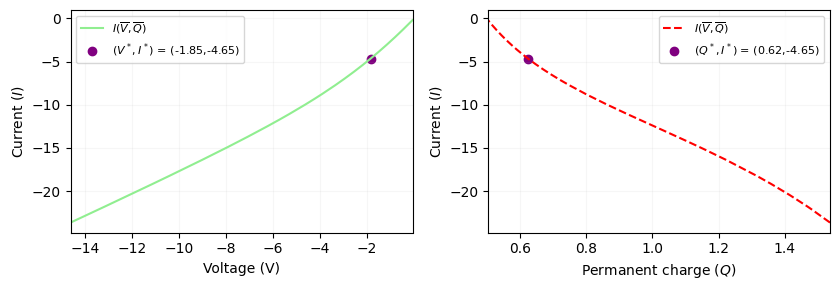

In [32]:
# plot the solutions
I_sol_ordQ =  (2 * Q0) * I_sol_ord[:-end]/ (alpha * H1)


fig, axs = plt.subplots(1, 2, figsize=(8.5, 3), squeeze=False)

axs[0, 0].plot(V_sol_ord[:-end], I_sol_ordQ, color='lightgreen', linestyle='-', markersize=1, label='$I(\overline{V},\overline{Q})$')
axs[0, 0].set_xlabel('Voltage (V)')
axs[0, 0].set_ylabel('Current $(I)$')
axs[0, 0].set_xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))  # Adjust the x-axis limits
axs[0, 0].scatter(V0, I_sol_ordQ[bifp], color='purple', label=f'$(V^*,I^*)$ = ({V0:.2f},{I_sol_ordQ[bifp]:.2f})')

axs[0, 0].legend(prop={'size': 8})
axs[0, 0].grid(True, alpha=0.1)


axs[0, 1].plot(Q_sol_ord[:-end], I_sol_ordQ, color='red', linestyle='--', markersize=1,label='$I(\overline{V},\overline{Q})$')
axs[0, 1].set_xlabel(r'Permanent charge $(Q)$')
axs[0, 1].set_ylabel('Current $(I)$')
axs[0, 1].set_xlim(np.min(Q_sol_ord[:-end]), np.max(Q_sol_ord[:-end]))  # Adjust the x-axis limits
axs[0, 1].scatter(Q0, I_sol_ordQ[bifp], color='purple', label=f'$(Q^*,I^*)$ = ({Q0:.2f},{I_sol_ordQ[bifp]:.2f})')

axs[0, 1].legend(prop={'size': 8})
axs[0, 1].grid(True, alpha=0.1)

plt.tight_layout() 
plt.show()

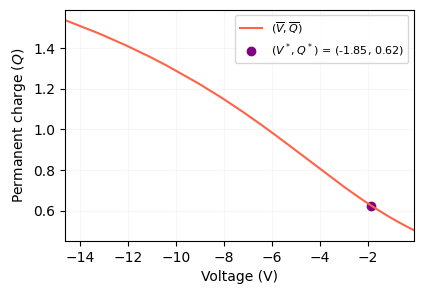

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3), squeeze=False)

axs[0, 0].plot(V_sol_ord[:-end], Q_sol_ord[:-end], color='tomato', linestyle='-', markersize=1, label='$(\overline{V},\overline{Q})$')
axs[0, 0].set_xlabel('Voltage (V)')
axs[0, 0].set_ylabel(r'Permanent charge $(Q)$')
axs[0, 0].scatter(V0, Q0, color='purple', label=f'$(V^*,Q^*)$ = ({V0:.2f}, {Q0:.2f})')
axs[0, 0].set_xlim(np.min(V_sol_ord[:-end]), np.max(V_sol_ord[:-end]))
axs[0, 0].legend(prop={'size': 8})

plt.grid(True, alpha=0.1)
plt.show()

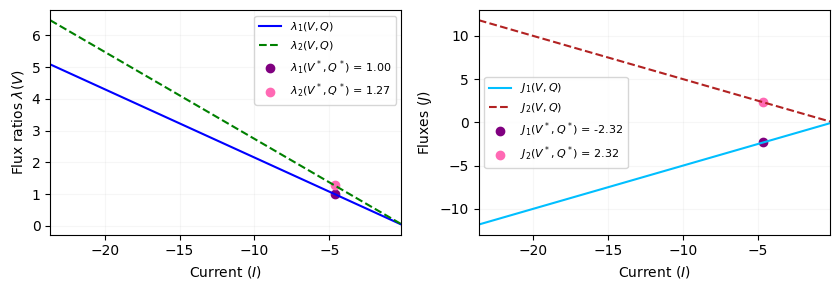

In [34]:
flux1 = 0.5 * (l0 - A0 + (-1) ** (k + 1) * I_sol_ord)
flux10 = alpha * (l0 - r0) * ((-1) ** (k + 1) * V0 + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))

flux_r1 = flux1 / flux10

flux1Q = (2 * Q0) * flux1/ (alpha * H1)


flux2 = 0.5 * (l0 - A0 + (-1) ** (k + 2) * I_sol_ord)
flux20 = alpha * (l0 - r0) * ((-1) ** (k + 2) * V0 + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))

flux_r2 = flux2 / flux20

flux2Q = (2 * Q0) * flux2/ (alpha * H1)

fig, axs = plt.subplots(1, 2, figsize=(8.5, 3), squeeze=False)

axs[0, 0].plot(I_sol_ordQ, flux_r1[:-end], color='blue', linestyle='-', markersize=1, label='$\lambda_1({V},{Q})$')
axs[0, 0].plot(I_sol_ordQ, flux_r2[:-end], color='green', linestyle='--', markersize=1, label='$\lambda_2({V},{Q})$')
axs[0, 0].set_xlabel('Current $(I)$')
axs[0, 0].set_ylabel(r'Flux ratios $\lambda(V)$')
axs[0, 0].set_xlim(np.min(I_sol_ordQ), np.max(I_sol_ordQ))
axs[0, 0].scatter(I_sol_ordQ[bifp], flux_r1[bifp], color='purple', label=f'$\lambda_1(V^*,Q^*)$ = {llmd_k[bifp]:.2f}')
axs[0, 0].scatter(I_sol_ordQ[bifp], flux_r2[bifp], color='hotpink', label=f'$\lambda_2(V^*,Q^*)$ = {llmd_k2[bifp]:.2f}')

axs[0, 0].legend(prop={'size': 8})
axs[0, 0].grid(True, alpha=0.1)

JJ1 = (2 * Q0) * jj_k/ (alpha * H1)
JJ2 = (2 * Q0) * jj_k2/ (alpha * H1)

#JJ0_1 = (2 * Q0) * jj_k_0/ (alpha * H1)
#JJ0_2 = (2 * Q0) * jj_k_02/ (alpha * H1)


axs[0, 1].plot(I_sol_ordQ, flux1Q[:-end], color='deepskyblue', linestyle='-', markersize=1, label='$J_1({V},{Q})$')
axs[0, 1].plot(I_sol_ordQ, flux2Q[:-end], color='firebrick', linestyle='--', markersize=1, label='$J_2({V},{Q})$')
axs[0, 1].set_xlabel('Current $(I)$')
axs[0, 1].set_ylabel('Fluxes $(J)$')

axs[0, 1].set_xlim(np.min(I_sol_ordQ), np.max(I_sol_ordQ))
#axs[0, 1].set_ylim(-50, 50)  
axs[0, 1].grid(True, alpha=0.1)
axs[0, 1].scatter(I_sol_ordQ[bifp], flux1Q[bifp], color='purple', label=f'$J_1(V^*,Q^*)$ = {flux1Q[bifp]:.2f}')
axs[0, 1].scatter(I_sol_ordQ[bifp], flux2Q[bifp], color='hotpink', label=f'$J_2(V^*,Q^*)$ = {flux2Q[bifp]:.2f}')
axs[0, 1].legend(prop={'size': 8})


plt.tight_layout() 
plt.show()
